# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## Read the CSV and Perform Basic Data Cleaning

In [16]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.drop(
    columns=[x for x in df.columns if len(df[x].unique())==1], 
    inplace=True
    )
df = pd.get_dummies(
    df, columns=['home_ownership', 
                 'verification_status', 
                 'issue_d', 
                 'initial_list_status', 
                 'next_pymnt_d', 
                 'application_type']
                )
df.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,0,0,0,1,0,1,0,1,1,0
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,0,0,1,0,1,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,0,0,1,0,1,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,0,0,1,0,1,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,0,0,0,1,0,1,0,1,1,0


## Split the Data into Training and Testing

In [24]:
# Create our features
X = df.drop(columns='loan_status')

# Create our target
y = df.loan_status

In [25]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [28]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   random_state=1, 
                                                   stratify=y)

## Data Pre-Processing

In [31]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [32]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [33]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier
Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [35]:
# Resample the training data with the BalancedRandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model = rf_model.fit(X_train_scaled, y_train)

In [37]:
# Calculated the balanced accuracy score
y_pred = rf_model.predict(X_test_scaled)
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred)}")

Balanced accuracy score: 0.6663453674494684


In [42]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,29,58
Actual 1,11,17107


In [41]:
# Print the imbalanced classification report
print('Imbalanced Classification Report:')
print(classification_report_imbalanced(y_test, y_pred))

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.72      0.33      1.00      0.46      0.58      0.31        87
   low_risk       1.00      1.00      0.33      1.00      0.58      0.36     17118

avg / total       1.00      1.00      0.34      1.00      0.58      0.36     17205



<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

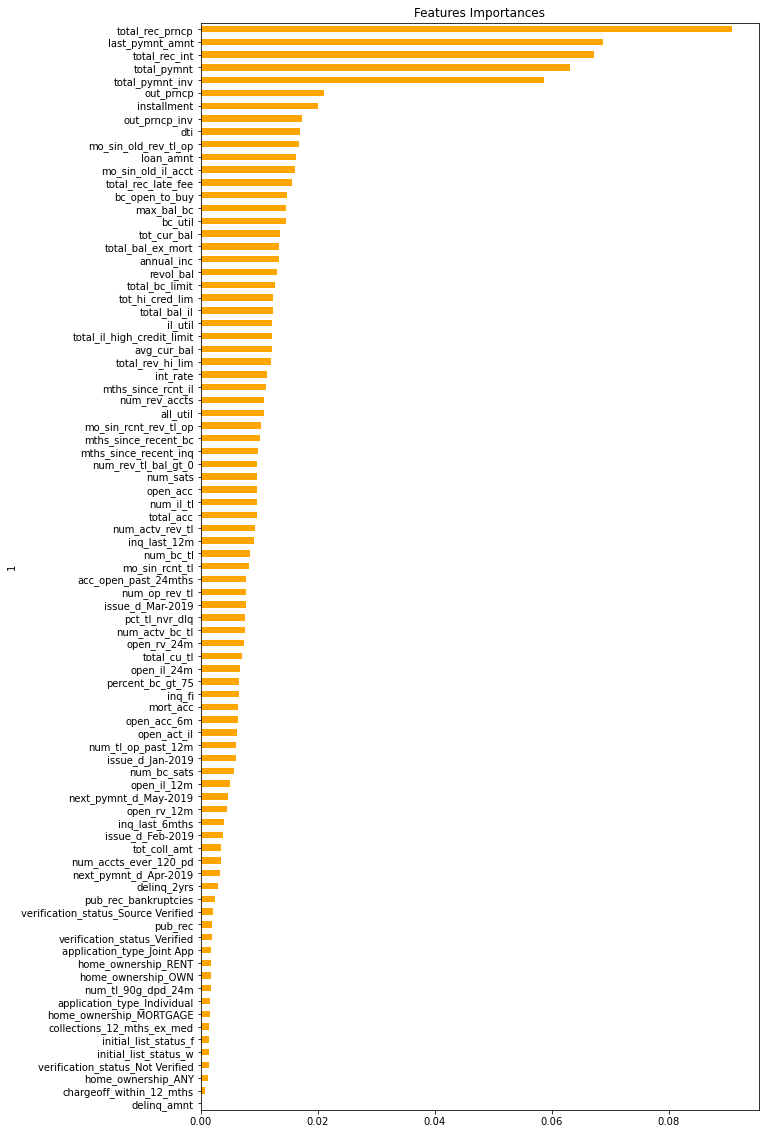

In [58]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_

importances_df = pd.DataFrame(sorted(zip(importances, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='orange', title= 'Features Importances', legend=False, figsize=(10,20))

### Easy Ensemble Classifier

In [50]:
# Train the Classifier
eec = EasyEnsembleClassifier(random_state=1)
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(random_state=1)

In [51]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test_scaled)
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred)}")

Balanced accuracy score: 0.9197678587975553


In [52]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix")
display(cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,78,9
Actual 1,976,16142


In [53]:
# Print the imbalanced classification report
print('Imbalanced Classification Report:')
print(classification_report_imbalanced(y_test, y_pred))

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.90      0.94      0.14      0.92      0.84        87
   low_risk       1.00      0.94      0.90      0.97      0.92      0.85     17118

avg / total       0.99      0.94      0.90      0.97      0.92      0.85     17205



### Final Questions

1. Which model had the best balanced accuracy score?

*   Easy Ensemble Classifier

2. Which model had the best recall score?

*   Random Forest Classifier

3. Which model had the best geometric mean score?

*   Easy Ensemble Classifier

4. What are the top three features?

*   total_rec_prncp
*   last_pymnt_amnt
*   total_rec_int